# **EDA**

In [228]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
import datetime as dt

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
sns.set_style('darkgrid')
sns.set_palette('rocket')

In [229]:
# train file
train = pd.read_csv("train.csv")
print(train.shape)
train.head()

(8523, 12)


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [230]:
train.isna().sum()*100/train.shape[0]

Item_Identifier               0.000000
Item_Weight                  17.165317
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.276428
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales             0.000000
dtype: float64

In [231]:
# Numeric Data Stats

train.describe(exclude='object')

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [232]:
# Object Data Stats

train.describe(include='object')

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
count,8523,8523,8523,8523,6113,8523,8523
unique,1559,5,16,10,3,3,4
top,FDW13,Low Fat,Fruits and Vegetables,OUT027,Medium,Tier 3,Supermarket Type1
freq,10,5089,1232,935,2793,3350,5577


In [233]:
cat_cols = train.select_dtypes(include = ['object', 'category']).columns.to_list()
num_cols = train.select_dtypes(include=[np.number]).columns.to_list()

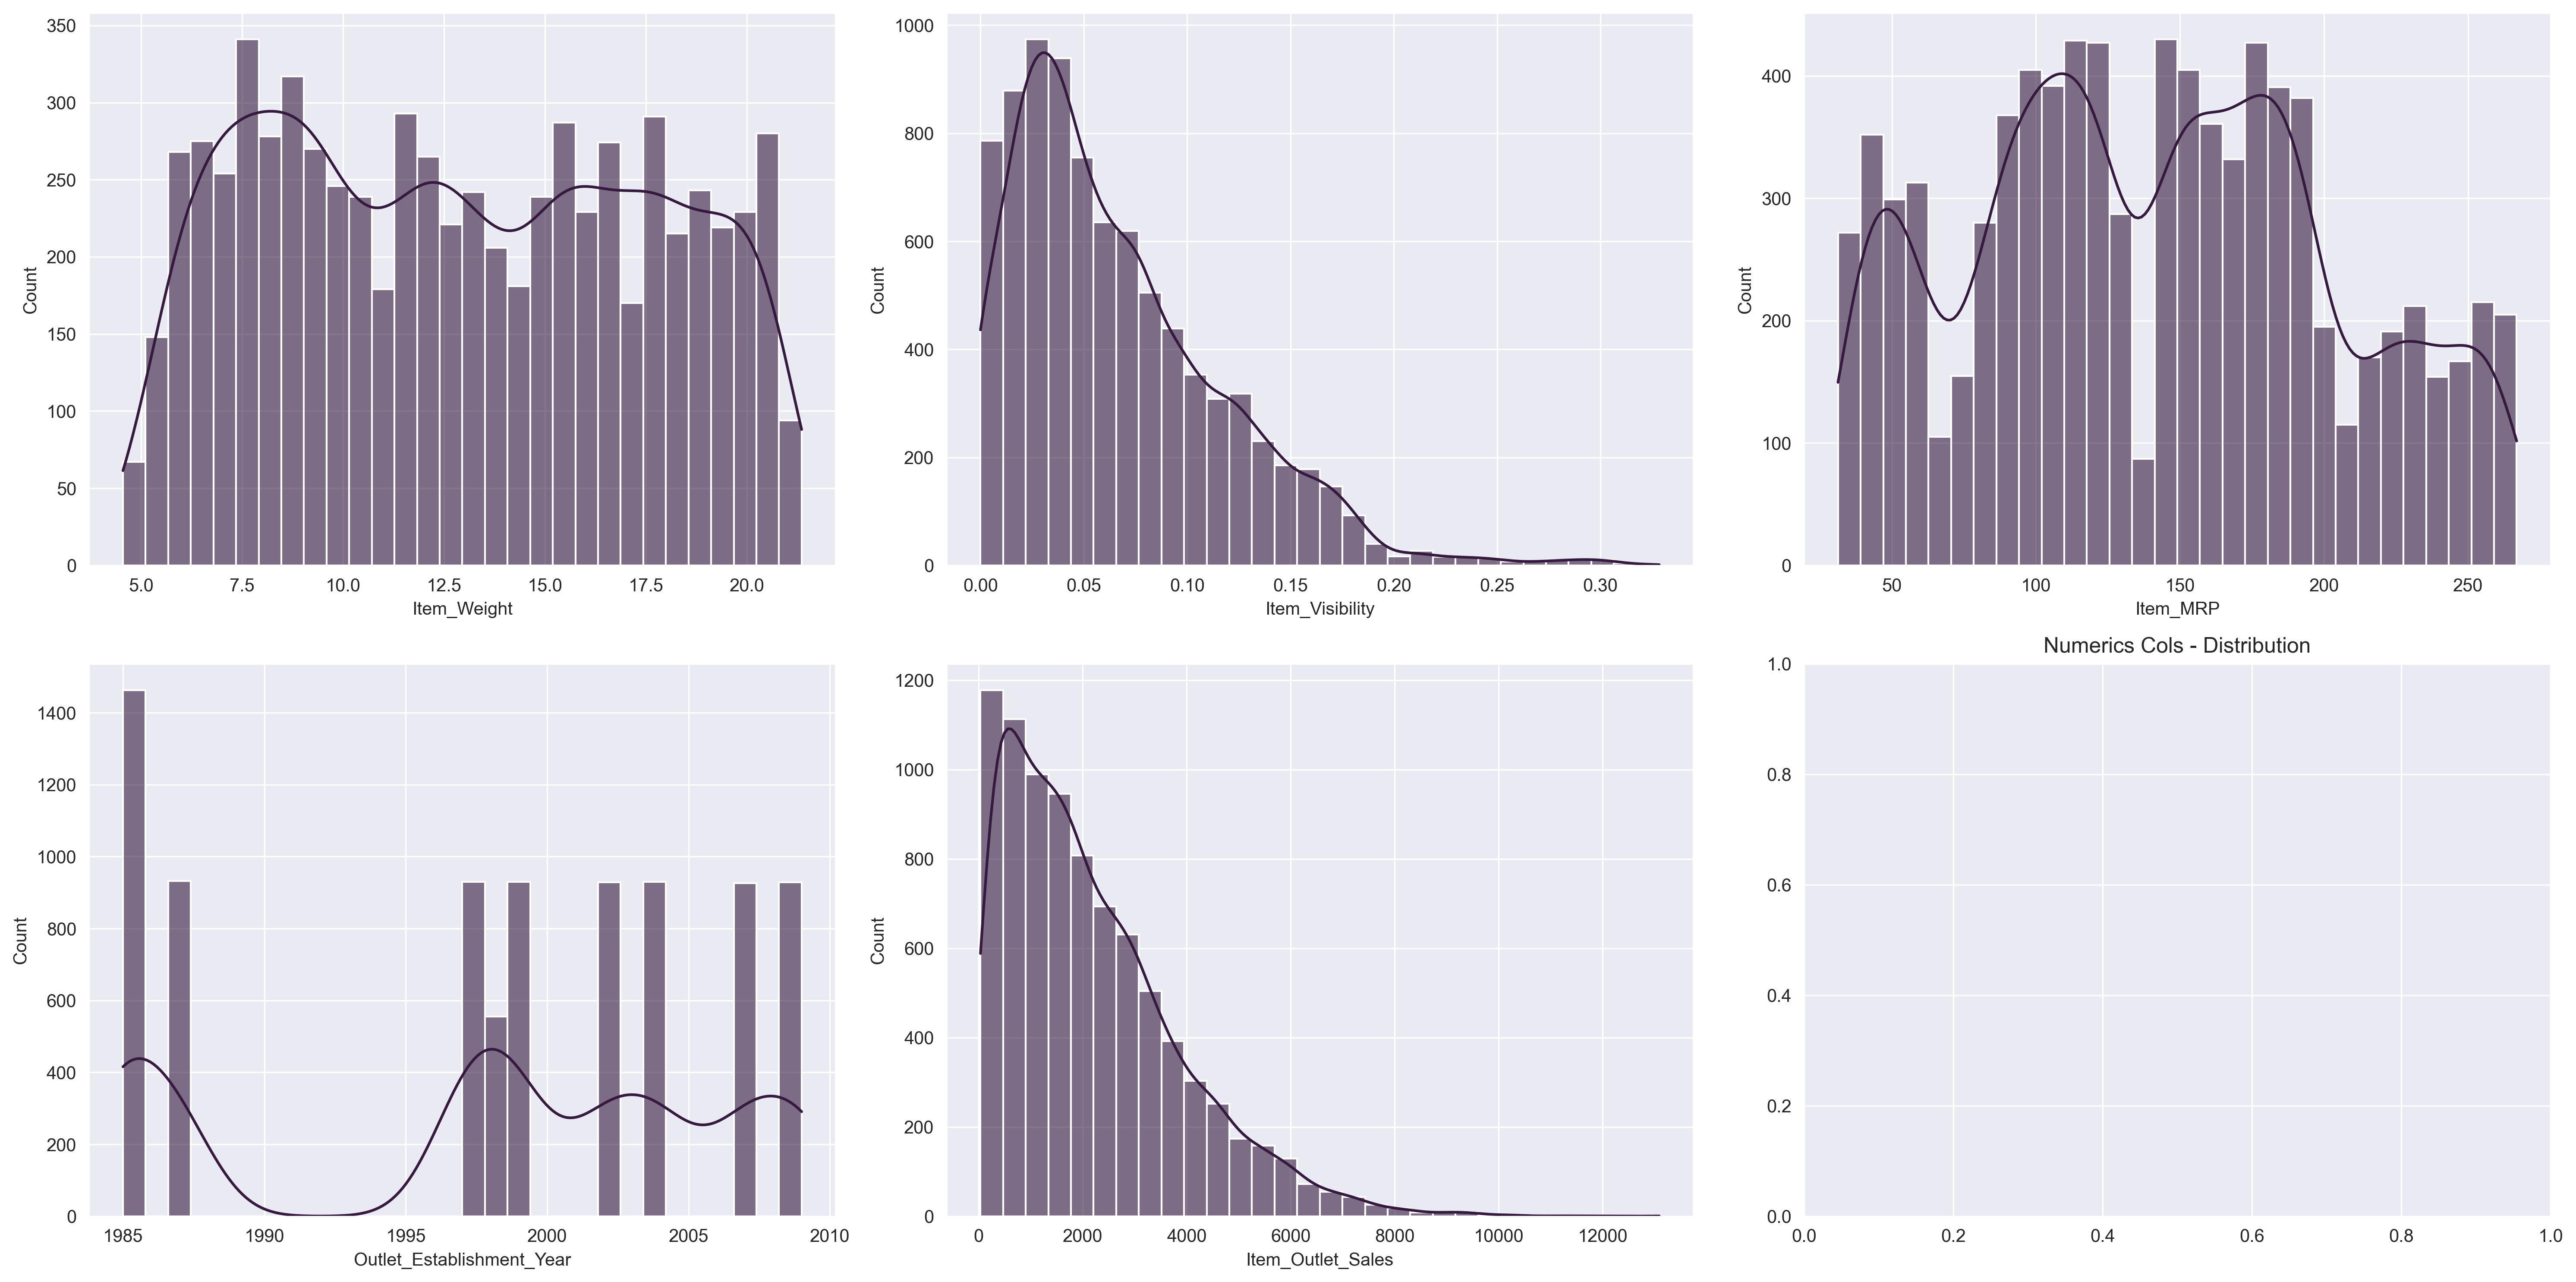

In [234]:
# Numeric Cols - Distribution

cols = 3
rows = (len(num_cols) + cols - 1) // cols

fig, ax = plt.subplots(rows, cols, figsize = (20, 10), dpi = 300)
for idx, col in enumerate(num_cols):
    r, c = idx // cols, idx % cols
    sns.histplot(train[col], bins = 30, alpha = 0.6, kde=True, ax = ax[r, c])

plt.title("Numerics Cols - Distribution")
plt.tight_layout()
plt.show()

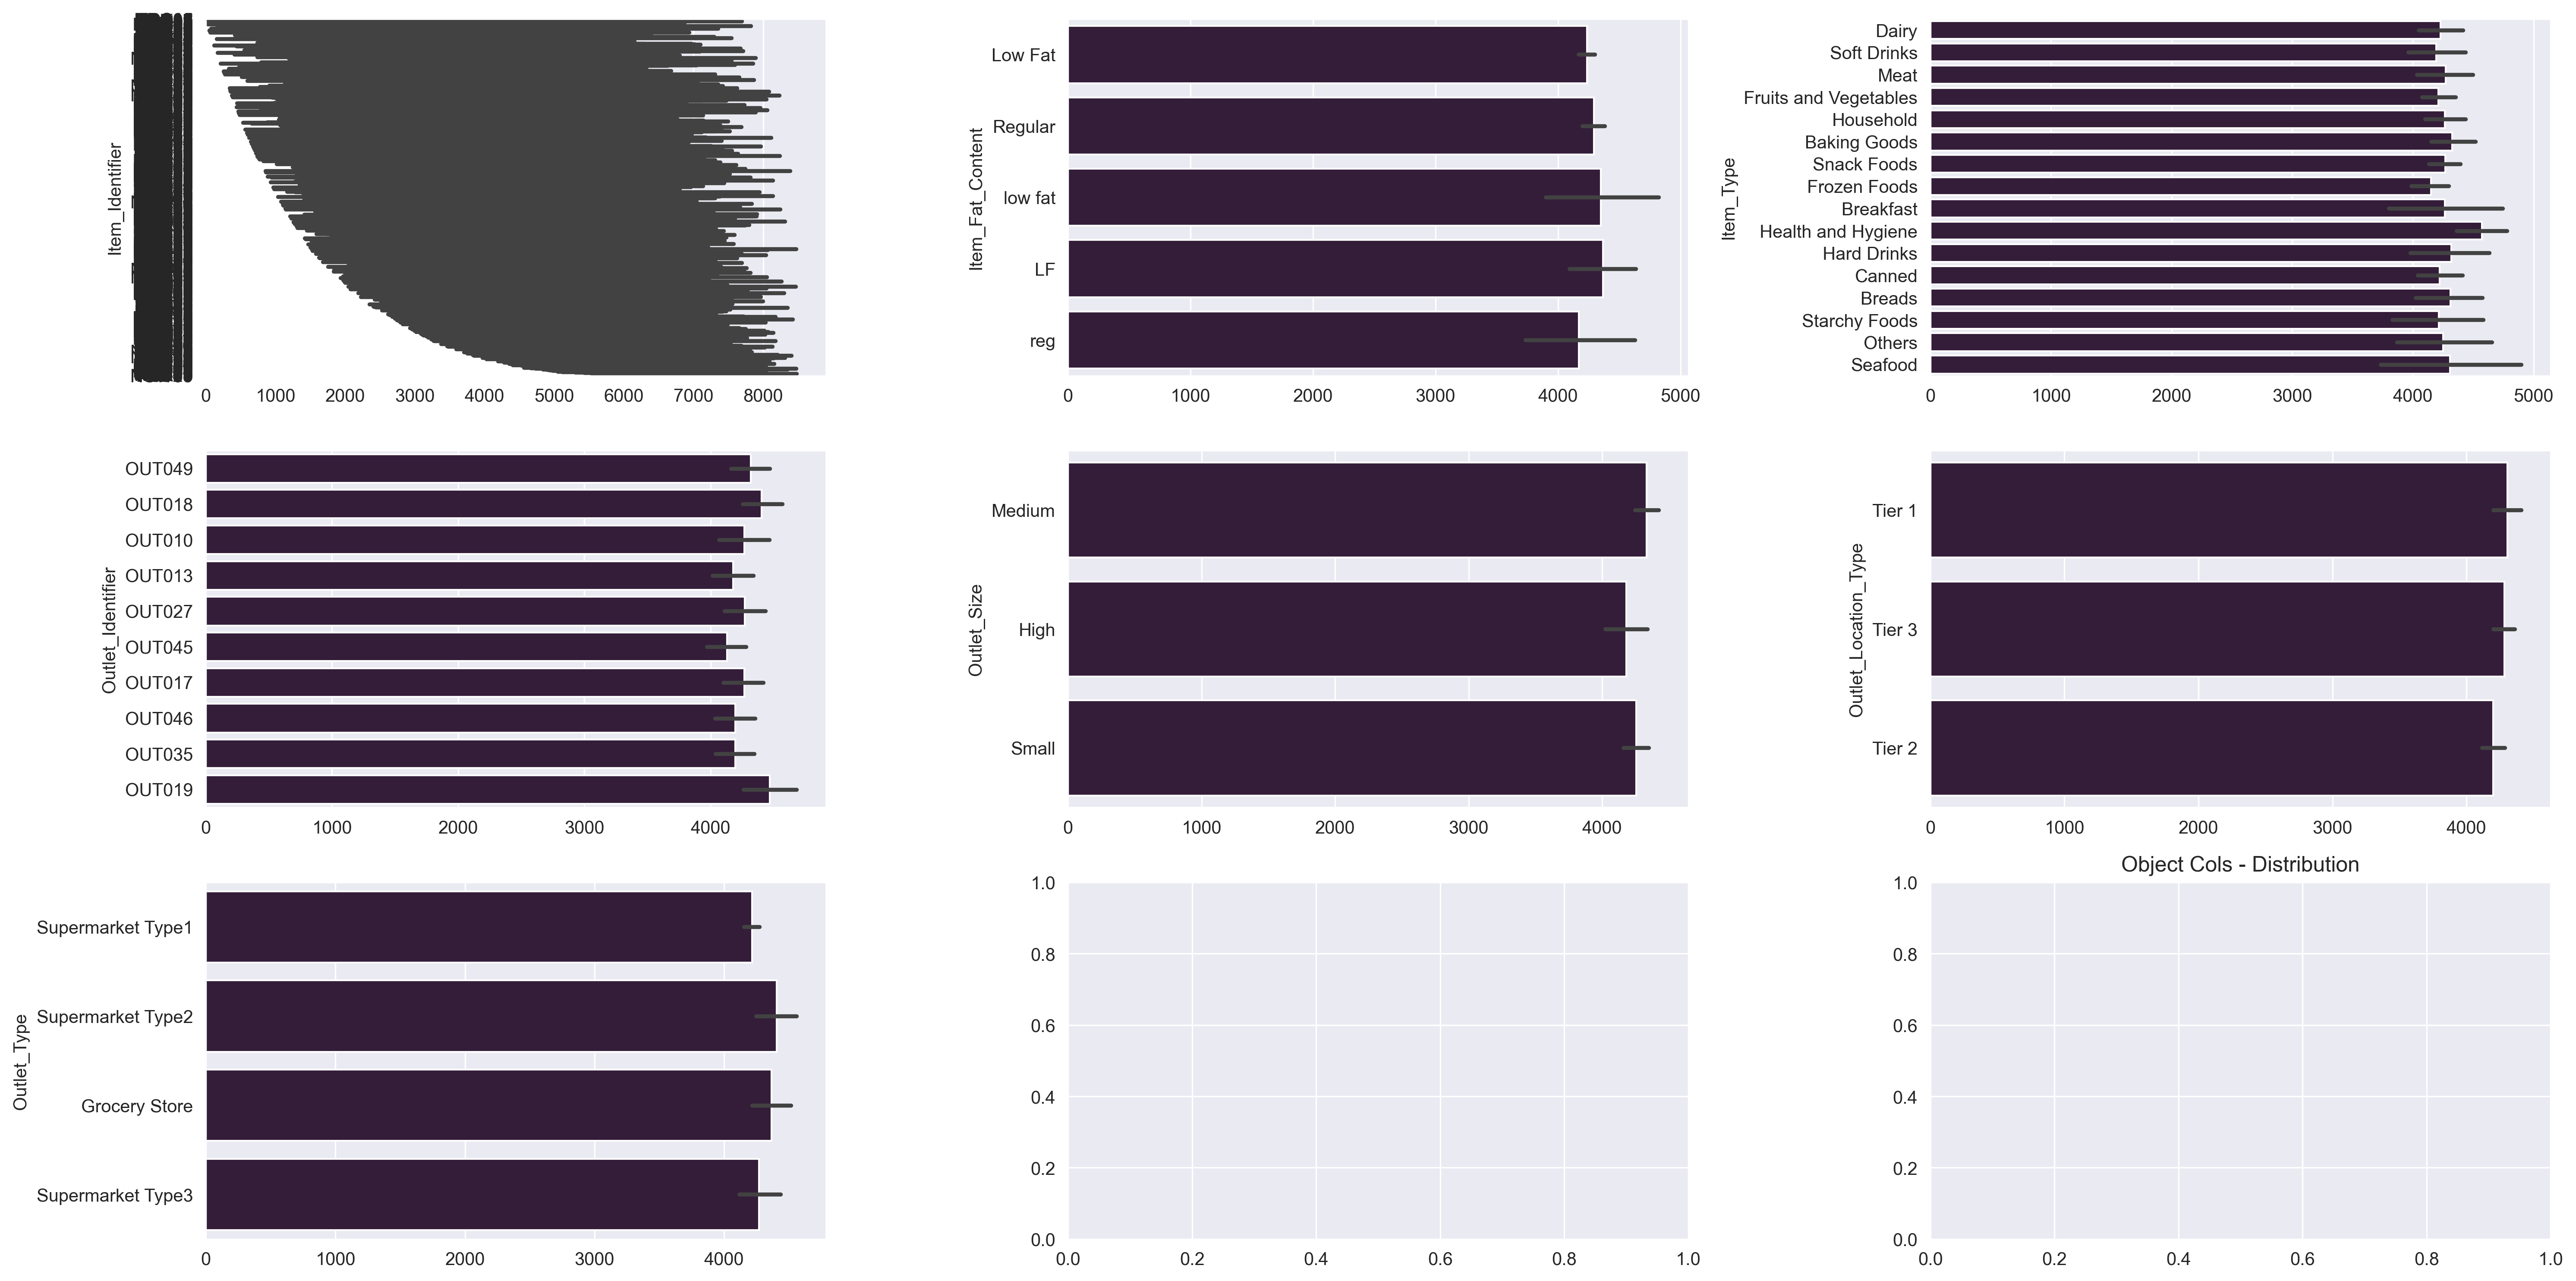

In [235]:
# Object Cols - Distribution

cols = 3
rows = (len(cat_cols) + cols - 1) // cols

fig, ax = plt.subplots(rows, cols, figsize = (20, 10), dpi = 300)
for idx, col in enumerate(cat_cols):
    r, c = idx // cols, idx % cols
    sns.barplot(train[col], ax = ax[r, c])

plt.title("Object Cols - Distribution")
plt.tight_layout()
plt.show()

### **Notes -**

##### **Cat Cols**
* All the category columns are very well balanced and little to no processing required
* Item_Fat_Content contains duplicates

##### **Numeric Cols**
* Heavily right skewed distributions can be observed
* Noisy fluctuated distributions was seen too
* Item_Visibility has to many 0s, intutively impossible
* **Target Variable** is showing massive skeweness

In [236]:
def outlier_check(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    return outliers.shape[0], outliers.shape[0] * 100 / df.shape[0], lower_bound, upper_bound

outlier_df = pd.DataFrame(columns=['Column', 'Outlier Count', 'Outlier Pct', 'LB', 'UB'])
for col in num_cols:
    count, Pct, lb, ub = outlier_check(train, col)
    outlier_df = pd.concat([outlier_df,pd.DataFrame({'Column': [col], 'Outlier Count': [count], 'Outlier Pct': [Pct]
                                                     , 'LB': [lb], 'UB': [ub]})], ignore_index=True)

outlier_df.sort_values(by='Outlier Pct', ascending=False)

,Column,Outlier Count,Outlier Pct,LB,UB
4,Item_Outlet_Sales,186,2.182330,-2566.326100,6501.869900
1,Item_Visibility,144,1.689546,-0.074404,0.195979
0,Item_Weight,0,0.000000,-3.340625,28.964375
2,Item_MRP,0,0.000000,-43.899300,323.369500
3,Outlet_Establishment_Year,0,0.000000,1961.500000,2029.500000


**Notes -**
* Has very minimal outliers, so clipping won't be an issue. If not use Yeo-Johnson on this
* Target variable is involved, so try log or Yeo-Johnson Transform. Else try with Tree based models

# **Cleaning & Feature Engineering**

### **Clean Up**

In [237]:
# Item_Fat_Content - Merge duplicates

fat_content_map = {
    'LF': 'Low Fat',
    'low fat': 'Low Fat',
    'reg': 'Regular'
}
train['Item_Fat_Content'] = train['Item_Fat_Content'].replace(fat_content_map)

In [238]:
# Item_Visibility - 0s handling

# mean vs median

(train.pivot_table(index = ['Item_Type'], columns = 'Outlet_Identifier', values = 'Item_Visibility', aggfunc = 'mean')\
- train.pivot_table(index = ['Item_Type'], columns = 'Outlet_Identifier', values = 'Item_Visibility', aggfunc = 'median')).style.background_gradient('coolwarm', axis = 0)



##### NOTE #####
# Difference is in 2nd decimal place, so we will use median.

Outlet_Identifier,OUT010,OUT013,OUT017,OUT018,OUT019,OUT027,OUT035,OUT045,OUT046,OUT049
Item_Type,,,,,,,,,,
Baking Goods,0.013824,0.007916,0.008003,0.010731,-0.014605,0.003700,0.005919,0.002415,0.007620,0.006947
Breads,0.007687,0.009246,0.007927,0.008598,0.013189,0.001989,0.011401,0.004890,0.002032,0.007692
Breakfast,0.008938,0.011995,0.023771,0.006875,0.033794,-0.000478,0.015395,0.014280,0.001278,0.012730
Canned,0.013343,0.015519,0.016317,0.018134,0.028507,0.010873,0.016135,0.016738,0.015106,0.020190
Dairy,0.012269,0.005680,-0.000661,0.008215,-0.001048,0.008412,0.004190,0.001739,0.011524,0.006225
Frozen Foods,0.020843,0.002754,0.010860,0.011103,0.021368,0.007174,-0.000009,0.005945,0.007449,0.008957
Fruits and Vegetables,0.012235,0.011441,0.013383,0.012226,0.019174,0.011658,0.010299,0.015723,0.011952,0.010560
Hard Drinks,-0.003866,-0.001740,0.007604,-0.002337,0.022529,0.008333,0.010656,0.011525,0.008430,0.001656
Health and Hygiene,0.028430,0.008315,0.011171,0.011816,0.003000,0.011645,0.005349,0.011762,0.003728,0.011881


In [239]:
vis_medians = train.groupby(['Outlet_Identifier', 'Item_Type'])['Item_Visibility'].median().to_dict()

def impute_item_visibility(df, medians):
    df = df.copy()
    df['Item_Visibility'] = df.apply(
        lambda row: medians.get((row['Outlet_Identifier'], row['Item_Type']), row['Item_Visibility'])
        if row['Item_Visibility'] == 0 else row['Item_Visibility'], axis=1
    )
    return df


train = impute_item_visibility(train, vis_medians)

### **Handling Nulls**

##### **Item_Weight**

In [240]:
# Item_Weight - 17%
# 1. Impute based on Item_Identifier median
# 2. Replace the rest with Item Type median

item_weight_medians = train.groupby('Item_Identifier')['Item_Weight'].median().dropna().to_dict()
item_type_medians = train.groupby('Item_Type')['Item_Weight'].median().dropna().to_dict()
global_weight_median = train['Item_Weight'].median()

def impute_item_weight(df, id_medians, type_medians, global_median):
    df = df.copy()
    def fill_weight(row):
        if pd.isna(row['Item_Weight']):
            return id_medians.get(row['Item_Identifier'], 
                       type_medians.get(row['Item_Type'], global_median))
        return row['Item_Weight']
    df['Item_Weight'] = df.apply(fill_weight, axis=1)
    return df


train = impute_item_weight(train, item_weight_medians, item_type_medians, global_weight_median)

##### **Outlet_Size**

In [241]:
# Outlet_Size - 28%

train[['Outlet_Identifier', 'Outlet_Establishment_Year','Outlet_Location_Type','Outlet_Type', 'Outlet_Size']].drop_duplicates().sort_values(['Outlet_Type','Outlet_Identifier'])

,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Location_Type,Outlet_Type,Outlet_Size
3,OUT010,1998,Tier 3,Grocery Store,NaN
23,OUT019,1985,Tier 1,Grocery Store,Small
4,OUT013,1987,Tier 3,Supermarket Type1,High
9,OUT017,2007,Tier 2,Supermarket Type1,NaN
19,OUT035,2004,Tier 2,Supermarket Type1,Small
8,OUT045,2002,Tier 2,Supermarket Type1,NaN
11,OUT046,1997,Tier 1,Supermarket Type1,Small
0,OUT049,1999,Tier 1,Supermarket Type1,Medium
1,OUT018,2009,Tier 3,Supermarket Type2,Medium
7,OUT027,1985,Tier 3,Supermarket Type3,Medium


In [242]:
train.groupby(['Outlet_Type','Outlet_Identifier'])['Item_Identifier'].nunique()

Outlet_Type        Outlet_Identifier
Grocery Store      OUT010               555
                   OUT019               528
Supermarket Type1  OUT013               932
                   OUT017               926
                   OUT035               930
                   OUT045               929
                   OUT046               930
                   OUT049               930
Supermarket Type2  OUT018               928
Supermarket Type3  OUT027               935
Name: Item_Identifier, dtype: int64

Based on above analysis -
* The Unique number items stored in outlets are pretty much same
* Given by Outlet_Type we can substitute the NULLs with Mode value

In [243]:
#  Given by Outlet_Type we can substitute the NULLs with Mode value

outlet_size_modes = (
    train.groupby('Outlet_Type')['Outlet_Size']
         .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
         .to_dict()
)
global_outlet_size = train['Outlet_Size'].mode()[0]


def impute_outlet_size(df, mode_map, global_mode):
    df = df.copy()
    df['Outlet_Size'] = df.apply(
        lambda row: mode_map.get(row['Outlet_Type'], global_mode) 
                    if pd.isna(row['Outlet_Size']) else row['Outlet_Size'], axis=1
    )
    return df

train = impute_outlet_size(train, outlet_size_modes, global_outlet_size)

## **Phase - 1**

### **Feature Engineering**

In [47]:
train['Item_Identifier'].str.slice(0,2).sort_values().unique()

array(['DR', 'FD', 'NC'], dtype=object)

In [48]:
train['Item_Identifier'].str.slice(0,3).sort_values().unique()

array(['DRA', 'DRB', 'DRC', 'DRD', 'DRE', 'DRF', 'DRG', 'DRH', 'DRI',
       'DRJ', 'DRK', 'DRL', 'DRM', 'DRN', 'DRO', 'DRP', 'DRQ', 'DRY',
       'DRZ', 'FDA', 'FDB', 'FDC', 'FDD', 'FDE', 'FDF', 'FDG', 'FDH',
       'FDI', 'FDJ', 'FDK', 'FDL', 'FDM', 'FDN', 'FDO', 'FDP', 'FDQ',
       'FDR', 'FDS', 'FDT', 'FDU', 'FDV', 'FDW', 'FDX', 'FDY', 'FDZ',
       'NCA', 'NCB', 'NCC', 'NCD', 'NCE', 'NCF', 'NCG', 'NCH', 'NCI',
       'NCJ', 'NCK', 'NCL', 'NCM', 'NCN', 'NCO', 'NCP', 'NCQ', 'NCR',
       'NCS', 'NCT', 'NCU', 'NCV', 'NCW', 'NCX', 'NCY', 'NCZ'],
      dtype=object)

In [49]:
train['Outlet_Identifier'].str.slice(0,3).sort_values().unique()

array(['OUT'], dtype=object)

**Notes -**
* Looks like 1st 2 letters in `Item_Identifier` is kinda of a Food Category, while rest is some kind of code.
* Post 3 letters in `Outlet_Identifier` is just the outlet number

In [50]:
# Replace Item_Fat_Content to NA for Non_Consumable Items

train['Item_Fat_Content'] = train.apply(lambda x : "NA" if "NC" in x['Item_Identifier'] else x['Item_Fat_Content'], axis=1)

In [51]:
# Replace Outlet_Establishment_Year with Age

curr_year = dt.datetime.now().year

train['Outlet_Age'] = curr_year - train['Outlet_Establishment_Year']
train.drop('Outlet_Establishment_Year', axis = 1, inplace=True)

* Though we can create Item_Category from above, creating so will create a multi-collinearity with Item_type (since, this is a granual version of Item_Category)

In [52]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer

# Label Encoding

le = LabelEncoder()
le_cols = ['Item_Identifier', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type']
le_dict = {}

def fit_label_encoders(df, cols):
    le_dict = {}
    df_copy = df.copy()
    for col in cols:
        le = LabelEncoder()
        df_copy[col] = le.fit_transform(df_copy[col])
        le_dict[col] = le
    return df_copy, le_dict

def transform_label_encoders(df, le_dict):
    df_copy = df.copy()
    for col, le in le_dict.items():
        df_copy[col] = le.transform(df_copy[col])
    return df_copy

def inverse_transform_label_encoders(df, le_dict):
    df_copy = df.copy()
    for col, le in le_dict.items():
        df_copy[col] = le.inverse_transform(df_copy[col])
    return df_copy

train, le_dict = fit_label_encoders(train, le_cols)


# One Hot Encoding

ohe_cols = ['Item_Fat_Content', 'Item_Type', 'Outlet_Type']

def fit_one_hot(df, cols):
    dummies = pd.get_dummies(df[cols], drop_first=True, dtype=int)
    df_copy = pd.concat([df.drop(columns=cols), dummies], axis=1)
    return df_copy, dummies.columns  # save OHE cols

def transform_one_hot(df, cols, ohe_columns):
    dummies = pd.get_dummies(df[cols], drop_first=True, dtype=int)
    dummies = dummies.reindex(columns=ohe_columns, fill_value=0)  # align with train
    df_copy = pd.concat([df.drop(columns=cols), dummies], axis=1)
    return df_copy


train, ohe_columns = fit_one_hot(train, ohe_cols)

In [53]:
import joblib

joblib.dump(le_dict, "label_encoders.pkl")

['label_encoders.pkl']

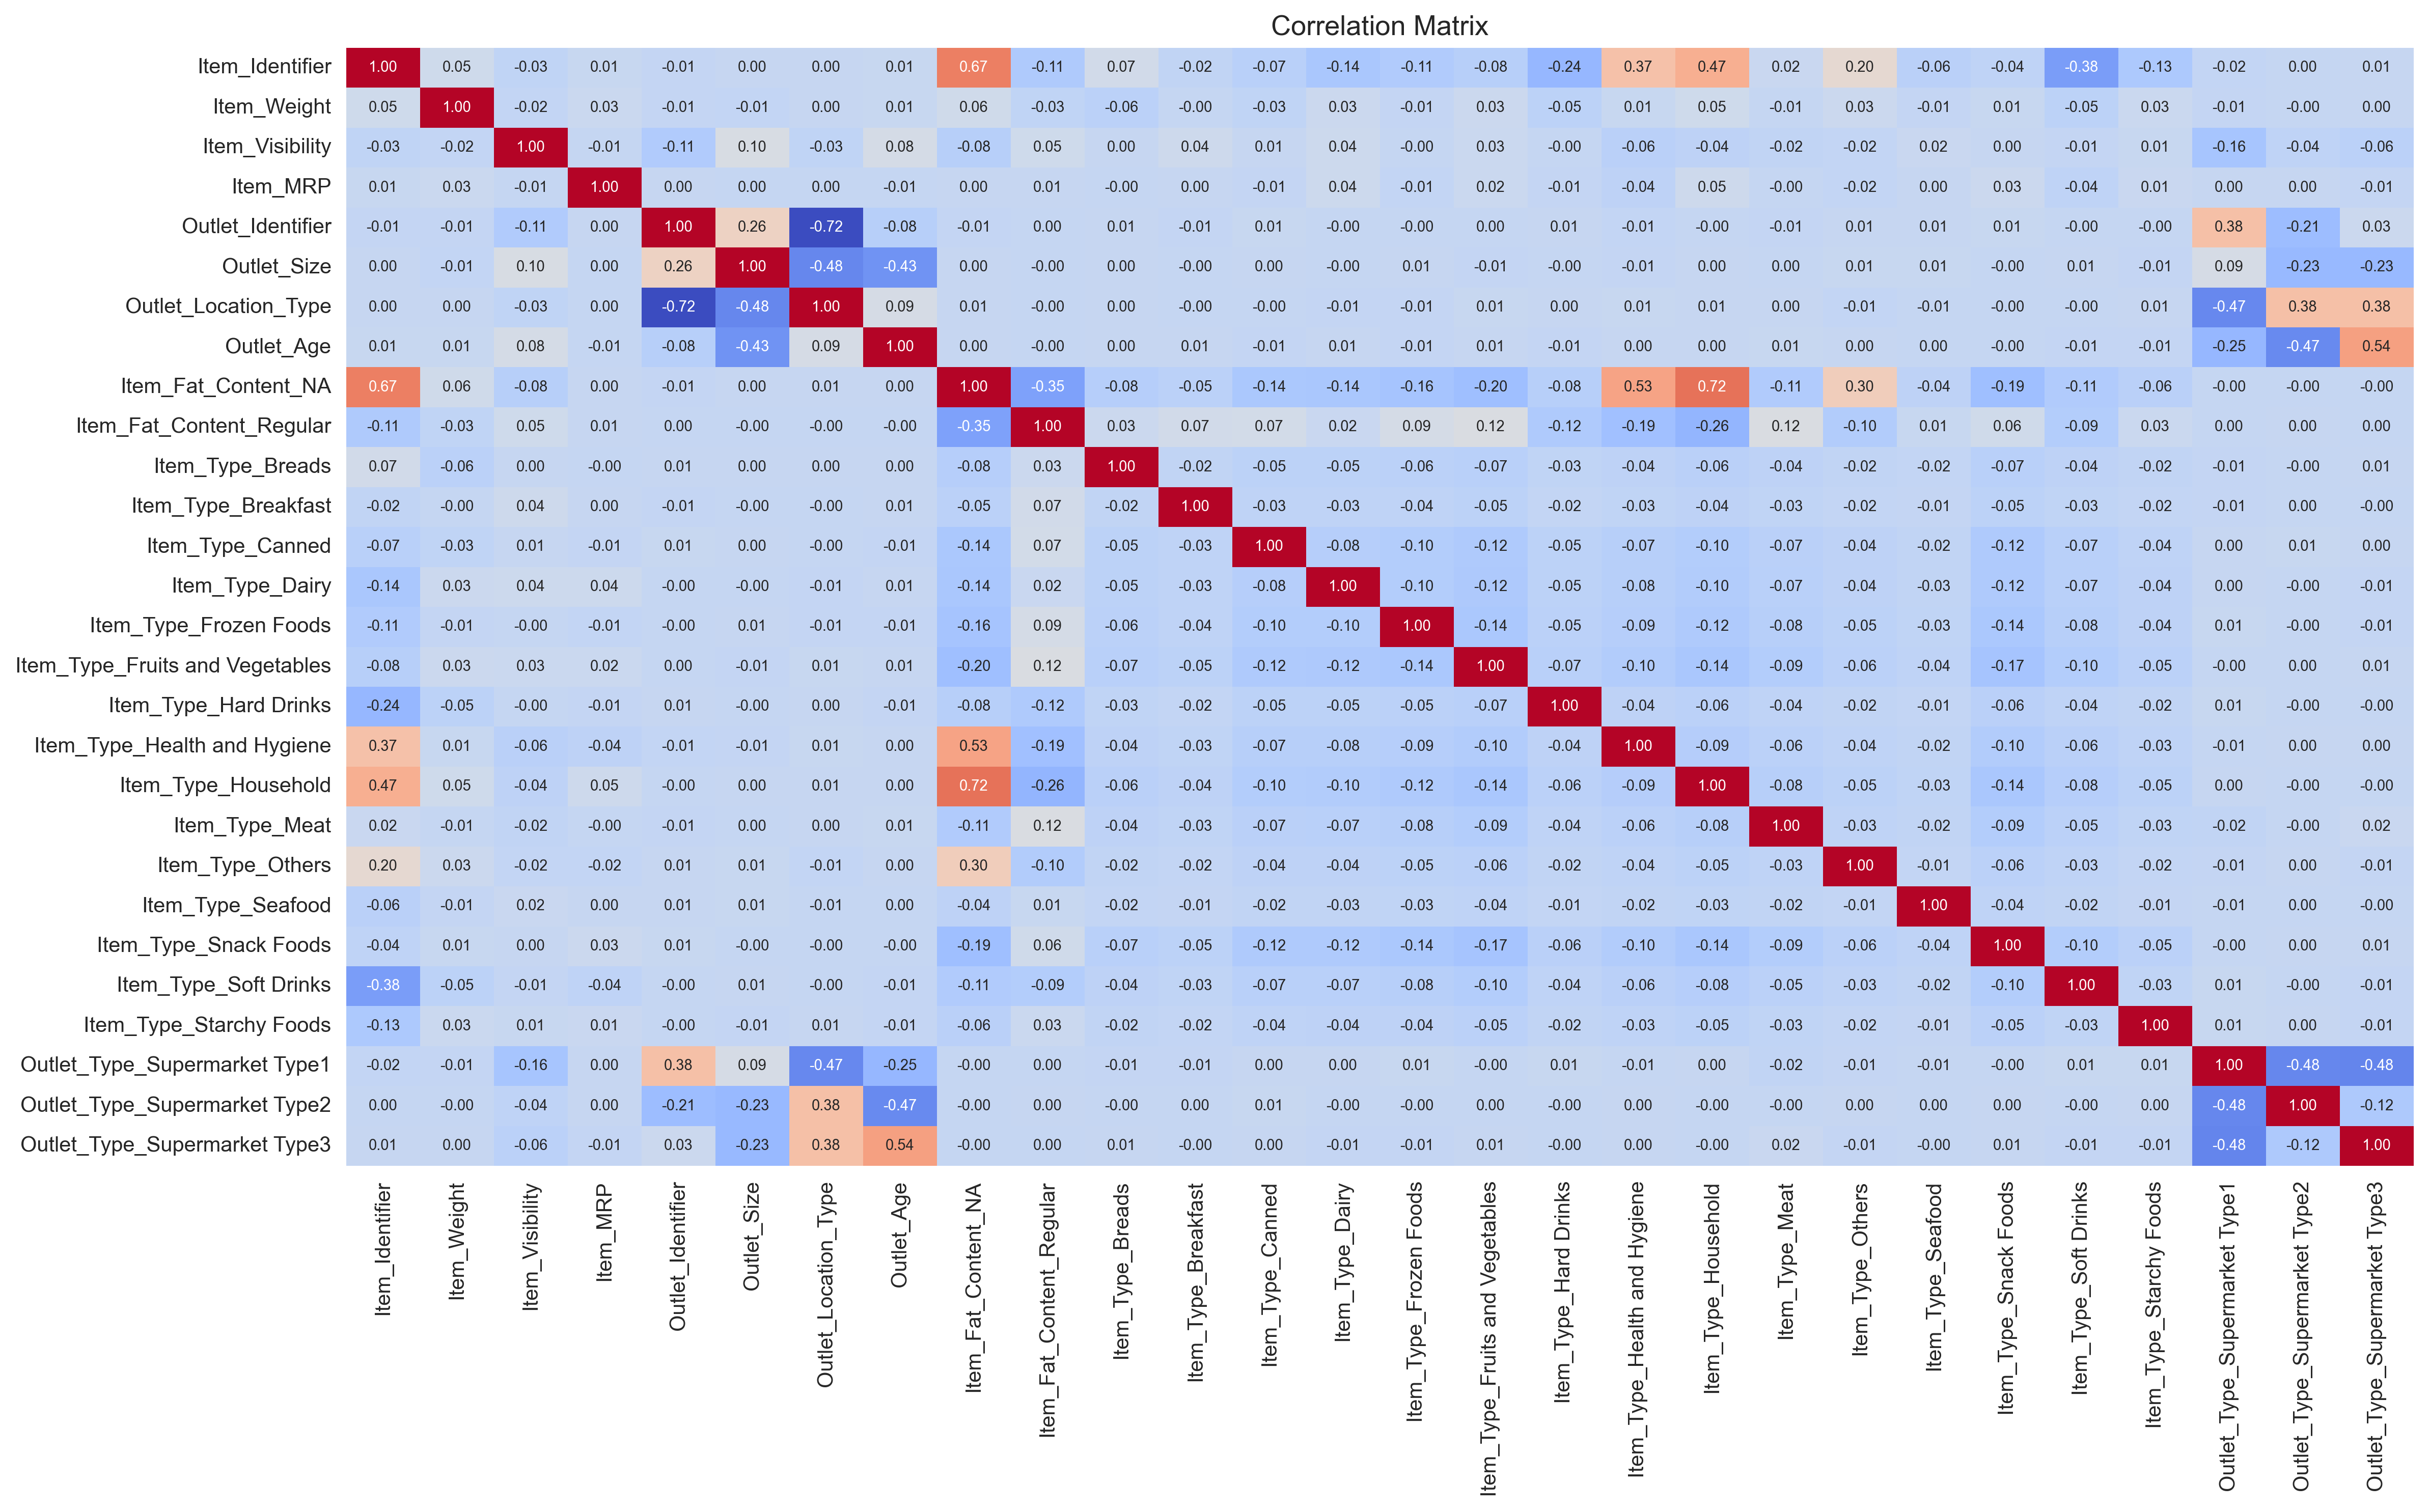

In [26]:
plt.figure(figsize=(16,10), dpi=300)
sns.heatmap(train.drop('Item_Outlet_Sales', axis = 1).corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=False, annot_kws={"size":7})
plt.title("Correlation Matrix", fontsize=13)
plt.tight_layout()
plt.show()

* Some inevitable correlations are there, rest are fine.

### **Feature Scaling**

In [113]:
target = train[['Item_Outlet_Sales']]
train = train.drop(['Item_Outlet_Sales'], axis = 1)

In [114]:
from scipy.stats import skew

for col in ['Item_Identifier', 'Item_Weight', 'Item_Visibility', 'Item_MRP','Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type','Outlet_Age']:
    skewness = skew(train[col].dropna())
    print(f"{col}: Skewness = {skewness:.2f}")

Item_Identifier: Skewness = -0.01
Item_Weight: Skewness = 0.07
Item_Visibility: Skewness = 1.31
Item_MRP: Skewness = 0.13
Outlet_Identifier: Skewness = -0.06
Outlet_Size: Skewness = -0.86
Outlet_Location_Type: Skewness = -0.21
Outlet_Age: Skewness = 0.40


1. Yeo-Johnson on `Item_Visibility` for Outlier reduction
2. StandardScaler on label encoded & numeric columns
3. Leave OHE based columns as it is
4. Scale the Identifier columns too, but careful about the cardinality. Check the Feature importance later

In [115]:
outlier_cols = ['Item_Visibility']
id_cols = ['Item_Identifier', 'Outlet_Identifier']
cont_cols = ['Item_Weight', 'Item_MRP', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Age']
binary_cols = ['Item_Fat_Content_NA', 'Item_Fat_Content_Regular',
       'Item_Type_Breads', 'Item_Type_Breakfast', 'Item_Type_Canned',
       'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
       'Item_Type_Health and Hygiene', 'Item_Type_Household', 'Item_Type_Meat',
       'Item_Type_Others', 'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2',
       'Outlet_Type_Supermarket Type3']

preprocessor = ColumnTransformer([
    ('yeo-johnson', PowerTransformer(method = 'yeo-johnson'), outlier_cols),
    ('standard_scaler', StandardScaler(), id_cols + cont_cols),
    ('passthrough', 'passthrough', binary_cols)
])

In [116]:
# scaling train set
train_scaled = preprocessor.fit_transform(train)

# scaling target variable - for skewness adjustment
target_scaler = PowerTransformer(method='yeo-johnson')
target_scaled = target_scaler.fit_transform(target)

In [117]:
import pickle
pickle.dump(preprocessor, open('./models/preprocessor.pkl', 'wb'))
pickle.dump(target_scaler, open('./models/target_scaler.pkl', 'wb'))

In [118]:
train.to_csv("./datasets/train - pre_scaled.csv", index = False)
target.to_csv("./datasets/target - pre_scaled.csv", index = False)

pd.DataFrame(train_scaled).to_csv("./datasets/train - scaled.csv", index = False)
pd.DataFrame(target_scaled).to_csv("./datasets/target - scaled.csv", index = False)

### **Test Set**

* Cleaning, Feature Processing

In [247]:
test = pd.read_csv("test.csv")
print(test.shape)
test.head()

(5681, 11)


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [248]:
# Check Nulls
test.isna().sum()*100/test.shape[0]

Item_Identifier               0.000000
Item_Weight                  17.180074
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.269671
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
dtype: float64

In [249]:
# Outlier Check

outlier_df = pd.DataFrame(columns=['Column', 'Outlier Count', 'Outlier Pct', 'LB', 'UB'])
for col in test.select_dtypes(include = np.number).columns:
    count, Pct, lb, ub = outlier_check(test, col)
    outlier_df = pd.concat([outlier_df,pd.DataFrame({'Column': [col], 'Outlier Count': [count], 'Outlier Pct': [Pct]
                                                     , 'LB': [lb], 'UB': [ub]})], ignore_index=True)

outlier_df.sort_values(by='Outlier Pct', ascending=False)

,Column,Outlier Count,Outlier Pct,LB,UB
1,Item_Visibility,113,1.989086,-0.072577,0.193086
0,Item_Weight,0,0.000000,-3.437500,28.782500
2,Item_MRP,0,0.000000,-43.009900,323.448500
3,Outlet_Establishment_Year,0,0.000000,1961.500000,2029.500000


In [250]:
##### Cleaning #####

# Fat Content 
test['Item_Fat_Content'] = test['Item_Fat_Content'].replace(fat_content_map)

# Item Visibility - 0s handling
test = impute_item_visibility(test, vis_medians)


########################################################################################################################


##### Handling NULLS #####

# Impute Item_Weight
test = impute_item_weight(test, item_weight_medians, item_type_medians, global_weight_median)

# Impute Outlet_Size
test = impute_outlet_size(test, outlet_size_modes, global_outlet_size)

In [251]:
test

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,Regular,0.038428,Dairy,87.3198,OUT017,2007,Small,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,Small,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,Small,Tier 2,Supermarket Type1
4,FDY38,13.600,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3
...,...,...,...,...,...,...,...,...,...,...,...
5676,FDB58,10.500,Regular,0.013496,Snack Foods,141.3154,OUT046,1997,Small,Tier 1,Supermarket Type1
5677,FDD47,7.600,Regular,0.142991,Starchy Foods,169.1448,OUT018,2009,Medium,Tier 3,Supermarket Type2
5678,NCO17,10.000,Low Fat,0.073529,Health and Hygiene,118.7440,OUT045,2002,Small,Tier 2,Supermarket Type1
5679,FDJ26,15.300,Regular,0.051038,Canned,214.6218,OUT017,2007,Small,Tier 2,Supermarket Type1


In [ ]:
##### Feature Engineering #####

# Item_Fat_Content -> NA

test['Item_Fat_Content'] = test.apply(lambda x : "NA" if "NC" in x['Item_Identifier'] else x['Item_Fat_Content'], axis=1)

# Age of Outlet
test['Outlet_Age'] = curr_year - test['Outlet_Establishment_Year']
test.drop('Outlet_Establishment_Year', axis = 1, inplace=True)

# Label Encoding
test = transform_label_encoders(test, le_dict)

# One Hot Encoding
test = transform_one_hot(test, ohe_cols, ohe_columns)


########################################################################################################################


##### Feature Scaling #####

test_scaled = preprocessor.transform(test)

In [123]:
test.to_csv("./datasets/test - pre_scaled.csv", index = False)

pd.DataFrame(test_scaled).to_csv("./datasets/test - scaled.csv", index = False)

## **Phase - 2**

In [244]:
# Normalied Item_Visibility
# train['Item_Visibility_Norm'] = train['Item_Visibility'] / train.groupby('Item_Identifier')['Item_Visibility'].transform('mean')

# Creating Item_Category from Item_Identifier
train['Item_Category'] = train['Item_Identifier'].str.slice(0,3)
train.drop('Item_Identifier', axis=1, inplace=True)

# Replace Item_Fat_Content to NA for Non_Consumable Items
train['Item_Fat_Content'] = train.apply(lambda x : "Not App" if "NC" in x['Item_Category'] else x['Item_Fat_Content'], axis=1)

# Replace Outlet_Establishment_Year with Age
curr_year = dt.datetime.now().year
train['Outlet_Age'] = curr_year - train['Outlet_Establishment_Year']
train.drop('Outlet_Establishment_Year', axis = 1, inplace=True)

# Create a Outlet Based compound feature
# train['Outlet_Context'] = (train['Outlet_Location_Type'] + " - "  + train['Outlet_Type'] + " - " + train['Outlet_Size'])
# train.drop(['Outlet_Location_Type', 'Outlet_Type', 'Outlet_Size'], axis=1, inplace=True)

# Create Item_MRP bands
# train["Item_MRP_bands"] = pd.qcut(train['Item_MRP'],
#         q = 5,
#         labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
#        )
# train.drop('Item_MRP', axis=1, inplace=True)

In [245]:
train

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Category,Outlet_Age
0,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,Medium,Tier 1,Supermarket Type1,3735.1380,FDA,26
1,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,Medium,Tier 3,Supermarket Type2,443.4228,DRC,16
2,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,Medium,Tier 1,Supermarket Type1,2097.2700,FDN,26
3,19.200,Regular,0.089689,Fruits and Vegetables,182.0950,OUT010,Small,Tier 3,Grocery Store,732.3800,FDX,27
4,8.930,Not App,0.039236,Household,53.8614,OUT013,High,Tier 3,Supermarket Type1,994.7052,NCD,38
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,High,Tier 3,Supermarket Type1,2778.3834,FDF,38
8519,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,Small,Tier 2,Supermarket Type1,549.2850,FDS,23
8520,10.600,Not App,0.035186,Health and Hygiene,85.1224,OUT035,Small,Tier 2,Supermarket Type1,1193.1136,NCJ,21
8521,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,Medium,Tier 3,Supermarket Type2,1845.5976,FDN,16


In [252]:
# Normalied Item_Visibility
#test['Item_Visibility_Norm'] = test['Item_Visibility'] / test.groupby('Item_Identifier')['Item_Visibility'].transform('mean')

# Creating Item_Category from Item_Identifier
test['Item_Category'] = test['Item_Identifier'].str.slice(0,3)
test.drop('Item_Identifier', axis=1, inplace=True)

# Replace Item_Fat_Content to NA for Non_Consumable Items
test['Item_Fat_Content'] = test.apply(lambda x : "Not App" if "NC" in x['Item_Category'] else x['Item_Fat_Content'], axis=1)

# Replace Outlet_Establishment_Year with Age
curr_year = dt.datetime.now().year
test['Outlet_Age'] = curr_year - test['Outlet_Establishment_Year']
test.drop('Outlet_Establishment_Year', axis = 1, inplace=True)

# Create a Outlet Based compound feature
# test['Outlet_Context'] = (test['Outlet_Location_Type'] + " - "  + test['Outlet_Type'] + " - " + test['Outlet_Size'])
# test.drop(['Outlet_Location_Type', 'Outlet_Type', 'Outlet_Size'], axis=1, inplace=True)

# Create Item_MRP bands
# test["Item_MRP_bands"] = pd.qcut(test['Item_MRP'],
#         q = 5,
#         labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
#        )
# test.drop('Item_MRP', axis=1, inplace=True)

In [253]:
train.to_csv("./data-phase2/train.csv", index=False)
test.to_csv("./data-phase2/test.csv", index=False)